In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter
import random
import pickle
import time
import os
import re

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
tf.__version__

'2.8.0'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2467454223488535935
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2920257947
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5282053712111526732
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [5]:
VERSION = "opd(-1,20,1)_UfcS"
PATH = './saves/'+str(VERSION)
if not os.path.exists(PATH):
    os.mkdir(PATH)
    folders=["data","model","loss_fig","feature_matrix"]
    for fn in folders:
        os.mkdir(PATH+"/"+fn)

# Load Data

In [6]:
def load_data_from_file(col,file_dir,drop_subset):
    df = pd.DataFrame(columns=col)
    for file in os.listdir(file_dir):
        df = df.append(pd.read_csv(file_dir+'/'+file, header=0,names = col))
    df=df.drop_duplicates(subset=drop_subset, keep='last')
    return df

In [7]:
def load_data(stock_per_strategy_file='./data/stock',strategy_data_file='./data/strategy',click_data_file='./data/click'):
    stock_col = ['mkID_or','stockID_or','strategyID_or','strategyCn']
    strategy_col = ['strategyID_or','strategyCN']
    click_col = ['userID_or','mkID_stockID','clicks_or']
    #load file
    stock_per_strategy = load_data_from_file(stock_col,stock_per_strategy_file,stock_col[0:3])
    strategy_data = load_data_from_file(strategy_col,strategy_data_file,strategy_col[0:2])
    click_data = load_data_from_file(click_col,click_data_file,click_col[0:2])
    return stock_per_strategy,strategy_data,click_data

stock_per_strategy,strategy_data,click_data = load_data()

print(stock_per_strategy.head())
print(strategy_data.head())
print(click_data.head())

  mkID_or stockID_or strategyID_or   strategyCn
0       1       0050     510016014      現金股利>3元
1       1       0050     510017001        外資連3買
2       1       0050     510017022      近一日籌碼大買
3       1       0050     510018006  股價在月線上&月線上揚
4       1       0050     510018009        月均線回升
  strategyID_or strategyCN
0     510011001         短多
1     510011002        中長多
2     510011003        籌碼多
3     510012001         短空
4     510012002        中長空
              userID_or mkID_stockID clicks_or
54   637648FC73CC58866Y    1__100000         2
56   637648FC73CC58866Y    1__056997         1
103  637086B8DA8A43059Y       1_2885         1
129  6374710EDA5D23337Y       1_2406         2
160  637065327824CC994Y      1__1409         2


In [8]:
click_data.head()

,userID_or,mkID_stockID,clicks_or
54,637648FC73CC58866Y,1__100000,2
56,637648FC73CC58866Y,1__056997,1
103,637086B8DA8A43059Y,1_2885,1
129,6374710EDA5D23337Y,1_2406,2
160,637065327824CC994Y,1__1409,2


# Data preprcessing

### Strategy

In [9]:
# #creat StrategyMap
# strategy_data = strategy_data.drop_duplicates()
# #因strategy_data有缺失
# IDL=strategy_data["strategyID_or"].unique()
# for i in  stock_per_strategy['strategyID_or'].unique():
#      if i not in IDL:
# #wrong        strategy_data.loc[len(strategy_data)] =[i,'缺失'+str(i)]
#         strategy_data=strategy_data.append(pd.DataFrame([[i,'缺失'+str(i)]],columns=strategy_data.columns), ignore_index=True)
#         print(strategy_data[strategy_data['strategyID_or']==i])

# ##
# print(strategy_data.shape)
# strategy_data.head()

### click

In [10]:
def sID_filter(x):
    if x.isdigit() and len(x)==4 :
        return True
    else:
        return False

In [11]:
def drop_wrong_click_data(click_data,sID_filter=lambda x:True):
    #drop test account('VAC.....',"...~Y")
    click_data=click_data[click_data['userID_or'].apply(lambda x: (len(x) == 18) and (x[-1]=='Y'))]
    temp=click_data.copy()
    temp[['mkID_or','stockID_or']] = [[id[0],id[-1]] for id in click_data['mkID_stockID'].str.split('_')]
    click_data=temp
    
    #drop wrong stockID
    click_data=click_data[~click_data['stockID_or'].isin(['','1','100000'])]
    click_data=click_data[click_data['mkID_or'].apply(lambda x: x in ['1','2','3','4','5','6'])]
    
    #drop outlier
    uatt_ub=click_data.groupby('userID_or').size().describe([.95]).at['95%']
    utotal_ub=click_data.groupby('userID_or')['clicks_or'].sum().describe([.95]).at['95%']    
    click_data=click_data.groupby('userID_or').filter(lambda x: len(x) < uatt_ub and x['clicks_or'].sum()<utotal_ub)
    
    click_data=click_data[click_data['stockID_or'].apply(lambda x: sID_filter(x))]
    return click_data.reset_index(drop=True)

click_data=drop_wrong_click_data(click_data)#,sID_filter)
click_data

,userID_or,mkID_stockID,clicks_or,mkID_or,stockID_or
0,637648FC73CC58866Y,1__056997,1,1,056997
1,637086B8DA8A43059Y,1_2885,1,1,2885
2,637065327824CC994Y,1__1409,2,1,1409
3,637065327824CC994Y,2__6182,2,2,6182
4,637065327824CC994Y,1__03785C,1,1,03785C
...,...,...,...,...,...
1386330,637165FC6BE6AB149Y,1_9945,5,1,9945
1386331,637165FC6BE6AB149Y,1_1513,4,1,1513
1386332,637165FC6BE6AB149Y,1_2887,3,1,2887
1386333,637165FC6BE6AB149Y,1_3045,2,1,3045


### Drop click data

In [12]:
or_click_data=click_data
# click_data=or_click_data

In [13]:
# describe
user_describe=pd.DataFrame()
user_describe['u_attentions'] = click_data.groupby('userID_or').size()
user_describe['u_total_clicks'] = click_data.groupby('userID_or')['clicks_or'].sum()
user_describe.describe([.25,.5,.75,.9])

,u_attentions,u_total_clicks
count,115668.000000,115668.000000
mean,11.985467,41.203194
std,10.131032,49.481714
min,1.000000,1.000000
25%,4.000000,9.000000
50%,8.000000,22.000000
75%,17.000000,53.000000
90%,28.000000,105.000000
max,44.000000,284.000000


In [14]:
stock_describe=pd.DataFrame()
stock_describe['s_attentions'] = click_data.groupby('stockID_or').size()
stock_describe['s_total_clicks'] = click_data.groupby('stockID_or')['clicks_or'].sum()
stock_describe.describe()

,s_attentions,s_total_clicks
count,12631.000000,12631.000000
mean,109.756551,377.316998
std,830.278890,3515.891328
min,1.000000,1.000000
25%,1.000000,2.000000
50%,2.000000,4.000000
75%,6.000000,20.000000
max,37227.000000,216372.000000


In [15]:
def non_drop(click_data):
    return click_data.reset_index(drop=True)

In [16]:
def slapdash_drop(click_data):
    click_data=click_data.groupby('userID_or').filter(lambda x: len(x) > 1)
    return click_data.reset_index(drop=True)

In [17]:
def rigorous_drop(lb_n,ub_1clk,ub_uatt,ub_utc,click_data):
    #drop outliers
    n=0
    while(n!=len(click_data)):
        n=len(click_data)
        #drop (click_n) outliers    
        click_data=click_data[click_data['clicks_or'].apply(lambda x: x < ub_1clk)]
        #drop (stock attention) outliers
        click_data=click_data.groupby('stockID_or').filter(lambda x: len(x) > lb_n)
        #drop (user attention/user total_click) outliers
        click_data=click_data.groupby('userID_or').filter(lambda x: lb_n < len(x) < ub_uatt)
        click_data=click_data.groupby('userID_or').filter(lambda x: x['clicks_or'].sum()<ub_utc)
    
    return click_data.reset_index(drop=True)

In [18]:
def mean_on_n_std(n,data):
    return data.mean()+(n*data.std())

In [19]:
def optimaize_drop(ua_lb,sa_lb,ub_nstd,click_data):   
    #drop outliers
    if ua_lb == -1:
        ua_lb=click_data.groupby('userID_or').size().describe()['50%']
    if sa_lb == -1:
        sa_lb=click_data.groupby('stockID_or').size().describe()['75%']
    c_ub=mean_on_n_std(ub_nstd,click_data['clicks_or'])
    ua_ub=mean_on_n_std(ub_nstd,click_data.groupby('userID_or').size())
    utc_ub=mean_on_n_std(ub_nstd,click_data.groupby('userID_or')['clicks_or'].sum())
    n=0
    while(n!=len(click_data)):
        n=len(click_data)
        #drop (click_n) outliers    
        click_data=click_data[click_data['clicks_or'].apply(lambda x: x < c_ub)]
        #drop (stock attention) outliers
        click_data=click_data.groupby('stockID_or').filter(lambda x: (sa_lb < len(x)))
        #drop (user attention/user total_click) outliers
        click_data=click_data.groupby('userID_or').filter(lambda x: ua_lb < len(x) < ua_ub)
        click_data=click_data.groupby('userID_or').filter(lambda x: x['clicks_or'].sum() < utc_ub)

    
    return click_data.reset_index(drop=True)

In [20]:
def click_data_pp(method,click_data):
    click_data['clicks_or'] =click_data['clicks_or'].astype(int)
    
    fun_dict={
        'non_drop' : non_drop,
        'slapdash_drop' : slapdash_drop,
        'rigorous_drop' : rigorous_drop,
        'optimaize_drop' : optimaize_drop
    }
    click_data=fun_dict[method[0]](*method[1],click_data)

    return click_data

'''
['non_drop',[]]
['slapdash_drop',[]]
['rigorous_drop',[lb_n,ub_1clk,ub_uatt,ub_utc]]
['optimaize_drop',[ua_lb(set -1 for auto),sa_lb,ub_nstd]]
'''
method=['optimaize_drop',[-1,20,1]]
click_data = click_data_pp(method,click_data)

click_data

,userID_or,mkID_stockID,clicks_or,mkID_or,stockID_or
0,6374253ACEA2E9416Y,2_6104,3,2,6104
1,6374253ACEA2E9416Y,1_1517,2,1,1517
2,6374253ACEA2E9416Y,1_2369,2,1,2369
3,6374253ACEA2E9416Y,1_2312,1,1,2312
4,6374253ACEA2E9416Y,1_2401,1,1,2401
...,...,...,...,...,...
519688,637165FC6BE6AB149Y,1_9945,5,1,9945
519689,637165FC6BE6AB149Y,1_1513,4,1,1513
519690,637165FC6BE6AB149Y,1_2887,3,1,2887
519691,637165FC6BE6AB149Y,1_3045,2,1,3045


### User

In [21]:
def generate_lost_user_data(click_data):
    user_data = pd.DataFrame()
    user_data["userID_or"]=click_data['userID_or'].unique()
    # user_data["Gender"] = np.zeros(user_data.shape[0], dtype = int)
    # user_data["Age"] = np.zeros(user_data.shape[0], dtype = int)
    # user_data["JobID"] = np.zeros(user_data.shape[0], dtype = int)
    # user_data["Locate"] = np.zeros(user_data.shape[0], dtype = int)

    return user_data

In [22]:
def user_data_pp(click_data):
    user_data = generate_lost_user_data(click_data)
    return user_data

user_data=user_data_pp(click_data)
##
user_data

,userID_or
0,6374253ACEA2E9416Y
1,6367282648E18E701Y
2,6377458CF3B92E098Y
3,63754780B8B55D884Y
4,63731586CC49DA481Y
...,...
37332,6369163E7AAB0E382Y
37333,63704287FC4C89888Y
37334,63765694F0E273687Y
37335,63688193D22B26814Y


### stock

In [23]:
def generate_lost_stock_data(stock_data,click_data):
    s_IDL=stock_data['stockID_or'].unique()
    c_IDL=click_data.drop_duplicates(subset=['stockID_or'])[['mkID_or','stockID_or']]
    c_IDL=c_IDL[c_IDL['stockID_or'].apply(lambda x : x not in s_IDL)]
    c_IDL['strategyList_or']=c_IDL.apply(lambda x: [], axis=1)
    stock_data=stock_data.append(c_IDL,ignore_index=True)
    
    return stock_data

In [24]:
def stock_data_pp(stock_per_strategy,click_data):
    gp=stock_per_strategy.groupby(['stockID_or'],as_index=False)
    stock_data = [[val['mkID_or'].mode().item(),key,np.unique(val['strategyID_or'])] for key, val in gp]
    stock_col = ['mkID_or','stockID_or','strategyList_or']
    stock_data=pd.DataFrame(stock_data,columns=stock_col)
    #因stock_per_strategy有缺失
    stock_data=generate_lost_stock_data(stock_data,click_data)
    #stock strategy數
    stock_data['strategy_n']=stock_data["strategyList_or"].apply(lambda x: len(x))
    stock_data=stock_data.astype({'mkID_or': 'str'})

    return stock_data

##
stock_data=stock_data_pp(stock_per_strategy,click_data)
stock_data

,mkID_or,stockID_or,strategyList_or,strategy_n
0,1,0050,"[510016014, 510017001, 510017022, 510018006, 5...",15
1,1,0051,"[510018006, 510018009, 510028001, 510028002, 5...",8
2,1,0052,"[510018006, 510018009, 510028001, 510028002, 5...",8
3,1,0053,"[510018006, 510018009, 510028001, 510028002, 5...",8
4,1,0054,"[510018006, 510018009, 510028001, 510028002, 5...",8
...,...,...,...,...
2292,1,100011,[],0
2293,3,TXOPM17050O2,[],0
2294,3,TXO17250O2,[],0
2295,5,PYPL,[],0


# Feature Engineering

### click feature

In [25]:
def cut2scale(x,lable_n):
    re = pd.qcut(x,lable_n,labels=False, duplicates='drop')
    re=re.fillna(0)
    re= ((re+1)*lable_n/((re.max()+1))).round(0)
    return re
#     return random.randint(1, 5)

In [26]:
def click_data_fe(click_data):
    lable_n=5
#     click_data['clicks'] = click_data.groupby(['userID_or'])['clicks_or'].transform(lambda x:cut2scale(x,lable_n))
#     click_data['clicks'] =click_data['clicks'].astype(int)
    click_data['clicks'] = click_data.groupby(['userID_or'])['clicks_or'].transform(lambda x: (x - x.mean()) / x.std())
    click_data['clicks'] =click_data['clicks'].astype('float64')
    return click_data
##
click_data=click_data_fe(click_data)
click_data.head()

,userID_or,mkID_stockID,clicks_or,mkID_or,stockID_or,clicks
0,6374253ACEA2E9416Y,2_6104,3,2,6104,2.429563
1,6374253ACEA2E9416Y,1_1517,2,1,1517,0.971825
2,6374253ACEA2E9416Y,1_2369,2,1,2369,0.971825
3,6374253ACEA2E9416Y,1_2312,1,1,2312,-0.485913
4,6374253ACEA2E9416Y,1_2401,1,1,2401,-0.485913


### User feature

In [27]:
def user_data_fe(user_data,click_data):
    temp = click_data.groupby('userID_or').size().to_dict()
    user_data['u_attentions'] = user_data['userID_or'].map(temp).fillna(0).astype(int)

    temp = click_data.groupby('userID_or')['clicks_or'].sum().to_dict()
    user_data['u_total_clicks'] = user_data['userID_or'].map(temp).fillna(0).astype(int)

    user_data=user_data[~(user_data['u_attentions']==0)].reset_index(drop=True)

    return user_data
##
user_data=user_data_fe(user_data,click_data)
user_data.head()

,userID_or,u_attentions,u_total_clicks
0,6374253ACEA2E9416Y,18,24
1,6367282648E18E701Y,19,71
2,6377458CF3B92E098Y,9,14
3,63754780B8B55D884Y,22,55
4,63731586CC49DA481Y,20,43


### stock feature

In [28]:
def stock_data_fe(stock_data,click_data):
    temp= click_data.groupby('stockID_or').size().to_dict()
    stock_data['s_attentions'] = stock_data['stockID_or'].map(temp).fillna(0).astype(int)

    temp = click_data.groupby('stockID_or')['clicks_or'].sum().to_dict()
    stock_data['s_total_clicks'] = stock_data['stockID_or'].map(temp).fillna(0).astype(int)

    stock_data=stock_data[~(stock_data['s_attentions']==0)].reset_index(drop=True)

    return stock_data

stock_data=stock_data_fe(stock_data,click_data)
stock_data.head()

,mkID_or,stockID_or,strategyList_or,strategy_n,s_attentions,s_total_clicks
0,1,0050,"[510016014, 510017001, 510017022, 510018006, 5...",15,2674,5253
1,1,0052,"[510018006, 510018009, 510028001, 510028002, 5...",8,44,77
2,1,0055,"[510017024, 510018006, 510028001, 510028002, 5...",8,97,167
3,1,0056,"[510016013, 510017001, 510028001, 510028002, 5...",12,2616,4999
4,1,006206,"[510017011, 510018006, 510028001, 510028003, 5...",9,23,40


### Label Encoder

In [29]:
def le_map(df,or_col,new_col):
    le=LabelEncoder()
    df[new_col] = le.fit_transform(df[or_col])
    IDmap={df[or_col][i]:df[new_col][i] for i in df.index}
    
    return df,IDmap

In [30]:
strategy_data,strategyID_map = le_map(strategy_data,'strategyID_or',"strategyID_le")

##
strategy_data.head()

,strategyID_or,strategyCN,strategyID_le
0,510011001,短多,0
1,510011002,中長多,1
2,510011003,籌碼多,2
3,510012001,短空,3
4,510012002,中長空,4


In [31]:
user_data,userID_map = le_map(user_data,'userID_or','userID_le')
##
user_data.head()

,userID_or,u_attentions,u_total_clicks,userID_le
0,6374253ACEA2E9416Y,18,24,27860
1,6367282648E18E701Y,19,71,174
2,6377458CF3B92E098Y,9,14,36515
3,63754780B8B55D884Y,22,55,32790
4,63731586CC49DA481Y,20,43,24652


In [32]:
stock_data,stockID_map = le_map(stock_data,"stockID_or","stockID_le")
stock_data,mkID_map = le_map(stock_data,"mkID_or","mkID_le")
stock_data['strategyList_le']=stock_data['strategyList_or'].transform(lambda x:[strategyID_map[ID] for ID in x])
##
stock_data.head()

,mkID_or,stockID_or,strategyList_or,strategy_n,s_attentions,s_total_clicks,stockID_le,mkID_le,strategyList_le
0,1,0050,"[510016014, 510017001, 510017022, 510018006, 5...",15,2674,5253,2,0,"[137, 155, 175, 183, 186, 270, 271, 279, 287, ..."
1,1,0052,"[510018006, 510018009, 510028001, 510028002, 5...",8,44,77,3,0,"[183, 186, 270, 271, 279, 287, 327, 330]"
2,1,0055,"[510017024, 510018006, 510028001, 510028002, 5...",8,97,167,4,0,"[177, 183, 270, 271, 279, 287, 327, 330]"
3,1,0056,"[510016013, 510017001, 510028001, 510028002, 5...",12,2616,4999,5,0,"[136, 155, 270, 271, 279, 287, 288, 294, 299, ..."
4,1,006206,"[510017011, 510018006, 510028001, 510028003, 5...",9,23,40,6,0,"[164, 183, 270, 272, 287, 294, 304, 327, 330]"


In [33]:
click_data['userID_le'] = click_data['userID_or'].map(userID_map)
click_data['stockID_le'] = click_data['stockID_or'].map(stockID_map)

##
click_data.head()

,userID_or,mkID_stockID,clicks_or,mkID_or,stockID_or,clicks,userID_le,stockID_le
0,6374253ACEA2E9416Y,2_6104,3,2,6104,2.429563,27860,1045
1,6374253ACEA2E9416Y,1_1517,2,1,1517,0.971825,27860,177
2,6374253ACEA2E9416Y,1_2369,2,1,2369,0.971825,27860,371
3,6374253ACEA2E9416Y,1_2312,1,1,2312,-0.485913,27860,334
4,6374253ACEA2E9416Y,1_2401,1,1,2401,-0.485913,27860,391


In [34]:
f = open('./saves/'+str(VERSION)+'/data/data.log', "a")
print(click_data[['clicks_or','clicks']].describe(), file = f)

click_data[['clicks_or','clicks']].describe()

,clicks_or,clicks
count,519693.000000,5.178720e+05
mean,2.188452,1.317161e-17
std,1.758030,9.634445e-01
min,1.000000,-2.334571e+00
25%,1.000000,-6.639591e-01
50%,1.000000,-4.196272e-01
75%,3.000000,4.196272e-01
max,9.000000,4.477215e+00


In [35]:
print(user_data[['u_attentions','u_total_clicks']].describe(), file = f)

user_data[['u_attentions','u_total_clicks']].describe()

,u_attentions,u_total_clicks
count,37337.000000,37337.000000
mean,13.918981,30.461017
std,3.872257,12.826484
min,9.000000,9.000000
25%,11.000000,21.000000
50%,13.000000,28.000000
75%,17.000000,38.000000
max,22.000000,90.000000


In [36]:
print(stock_data[['strategy_n','s_attentions','s_total_clicks']].describe(), file = f)
f.close()

stock_data[['strategy_n','s_attentions','s_total_clicks']].describe()

,strategy_n,s_attentions,s_total_clicks
count,1577.000000,1577.000000,1577.000000
mean,10.147749,329.545339,721.194039
std,7.801657,855.827356,1998.451724
min,0.000000,21.000000,28.000000
25%,5.000000,41.000000,83.000000
50%,9.000000,88.000000,184.000000
75%,14.000000,274.000000,583.000000
max,39.000000,13600.000000,36153.000000


In [37]:
scaler=MinMaxScaler(feature_range=(0,1))
stock_data[['s_attentions','s_total_clicks']] = scaler.fit_transform(stock_data[['s_attentions','s_total_clicks']])
user_data[['u_attentions','u_total_clicks']] = scaler.fit_transform(user_data[['u_attentions','u_total_clicks']])

# Data format

In [57]:
def data_format(strategyID_map,click_data, user_data, stock_data):
    #strategyList padding
    users = user_data[['userID_le','u_attentions','u_total_clicks']]
    stocks= stock_data[['stockID_le','mkID_le','s_attentions','s_total_clicks','strategyList_le']]
    clicks = click_data[['userID_le','stockID_le', 'clicks']]
    magic=max(strategyID_map.values())
    strategyID_map['0']=magic
    for i in range(len(stocks)):
        stocks.at[i,'strategyList_le'] = stocks.at[i,'strategyList_le']+[magic]*(40 - len(stocks.at[i,'strategyList_le']))
    data = pd.merge(pd.merge(clicks, users), stocks)
    target_fields = ['clicks']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    features = features_pd.values
    targets_values = targets_pd.values
    stocksid2idx = {val[0]:i for i, val in enumerate(stocks.values)}
    usersid2idx = {val[0]:i for i, val in enumerate(users.values)}
    return features,targets_values,clicks, users, stocks,stocksid2idx,usersid2idx

features,targets_values,clicks, users, stocks,stocksid2idx,usersid2idx=\
    data_format(strategyID_map,click_data, user_data, stock_data)

In [59]:
pickle.dump((user_data,stock_data,click_data,strategy_data), open('./saves/'+str(VERSION)+'/data/data_pp.p', 'wb'))
pickle.dump((features, targets_values, users, stocks, clicks, stockID_map,strategyID_map,userID_map,mkID_map,stocksid2idx,usersid2idx), open('./saves/'+str(VERSION)+'/data/data_fm.p', 'wb'))

In [60]:
def load_data_from_pickle(filename):
    return pickle.load(open(filename, mode='rb'))

features, targets_values, users, stocks, clicks,  \
        stockID_map,strategyID_map,userID_map,mkID_map,stocksid2idx,usersid2idx \
            = load_data_from_pickle('./saves/'+str(VERSION)+'/data/data_fm.p')

user_data,stock_data,click_data,strategy_data \
    = load_data_from_pickle('./saves/'+str(VERSION)+'/data/data_pp.p') 

In [61]:
def declaration_variables(features,strategyID_map):
    global uid_max,sid_max,mid_max,ssid_max
    uid_max = max(features.take(0,1)) + 1
    sid_max = max(features.take(1,1))+ 1
    mid_max = max(features.take(4,1))+ 1
    ssid_max = max(strategyID_map.values()) + 1
    global embed_dim,batch_size,learning_rate
    embed_dim = 32
    batch_size = 256
    learning_rate = 0.0001
    
declaration_variables(features,strategyID_map)

In [62]:
def get_inputs():
    u_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='u_id')  
    u_attentions = tf.keras.layers.Input(shape=(1,), dtype='float32', name='u_attentions')
    u_total_clicks = tf.keras.layers.Input(shape=(1,), dtype='float32', name='u_total_clicks')
    s_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='s_id') 
    m_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='m_id') 
    s_strategyList = tf.keras.layers.Input(shape=(40,), dtype='int32', name='s_strategyList') 
    s_attentions = tf.keras.layers.Input(shape=(1,), dtype='float32', name='s_attentions') 
    s_total_clicks = tf.keras.layers.Input(shape=(1,), dtype='float32', name='s_total_clicks') 
    
    return u_id,u_attentions,u_total_clicks,s_id, m_id, s_strategyList,s_attentions,s_total_clicks

In [63]:
def get_user_embedding(u_id):
    u_id_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='u_id_embed_layer')(u_id)
    
    return u_id_embed_layer

In [64]:
def get_user_feature_layer(u_id_embed_layer,u_attentions,u_total_clicks):
    #
    u_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="u_id_fc_layer", activation='relu')(u_id_embed_layer)
    u_attentions_fc_layer = tf.keras.layers.Dense(embed_dim, name="u_attentions_fc_layer", activation='relu')(u_attentions)
    u_total_clicks_fc_layer = tf.keras.layers.Dense(embed_dim, name="u_total_clicks_fc_layer", activation='relu')(u_total_clicks)
    #
    u_id_fc_layer = tf.keras.layers.Reshape([1 * 32])(u_id_fc_layer)
    user_combine_layer = tf.keras.layers.concatenate([u_id_fc_layer,u_attentions_fc_layer,u_total_clicks_fc_layer])
    user_combine_layer = tf.keras.layers.Dense(400, activation='relu')(user_combine_layer)

    user_combine_layer_flat = tf.keras.layers.Reshape([400], name="user_combine_layer_flat")(user_combine_layer)
    return user_combine_layer, user_combine_layer_flat

In [65]:
def get_stock_embedding(s_id, m_id):
    s_id_embed_layer = tf.keras.layers.Embedding(sid_max, embed_dim, input_length=1, name='stock_id_embed_layer')(s_id)
    m_id_embed_layer = tf.keras.layers.Embedding(mid_max, embed_dim // 2, input_length=1, name='stock_mkID_embed_layer')(m_id)
    
    return s_id_embed_layer,m_id_embed_layer

In [66]:
def get_stock_strategies_layers(s_strategyList):
    s_strategyList_embed_layer = tf.keras.layers.Embedding(ssid_max, embed_dim*2, input_length=40, name='s_strategyList_embed_layer')(s_strategyList)
    s_strategyList_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(s_strategyList_embed_layer)

    return s_strategyList_embed_layer

In [67]:
def get_stock_feature_layer(s_id_embed_layer,m_id_embed_layer,s_attentions,s_total_clicks,s_strategyList_embed_layer):
    #
    s_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="stock_id_fc_layer", activation='relu')(s_id_embed_layer)
    m_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="stock_mkID_fc_layer", activation='relu')(m_id_embed_layer)
    s_attentions_fc_layer = tf.keras.layers.Dense(embed_dim, name="s_attentions_fc_layer", activation='relu')(s_attentions)
    s_total_clicks_fc_layer = tf.keras.layers.Dense(embed_dim, name="s_total_clicks_fc_layer", activation='relu')(s_total_clicks)
    #
    s_strategyList_fc_layer = tf.keras.layers.Dense(embed_dim*2, name="s_strategyList_fc_layer", activation='relu')(s_strategyList_embed_layer)
    #
    s_id_fc_layer = tf.keras.layers.Reshape([1 * 32])(s_id_fc_layer)
    m_id_fc_layer = tf.keras.layers.Reshape([1 * 32])(m_id_fc_layer)
    s_strategyList_fc_layer = tf.keras.layers.Reshape([1 * 64])(s_strategyList_fc_layer)
    stock_combine_layer = tf.keras.layers.concatenate([s_id_fc_layer,m_id_fc_layer,s_strategyList_fc_layer,s_attentions_fc_layer, s_total_clicks_fc_layer])
    stock_combine_layer = tf.keras.layers.Dense(400, activation='relu')(stock_combine_layer)
    
    stock_combine_layer_flat = tf.keras.layers.Reshape([400], name="stock_combine_layer_flat")(stock_combine_layer)
    return stock_combine_layer, stock_combine_layer_flat

In [68]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [53]:
class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': [],'epo_train':[],'epo_test':[]}
        #輸入
        u_id,u_attentions,u_total_clicks,s_id, m_id, s_strategyList,s_attentions,s_total_clicks\
            = get_inputs()
        # User嵌入向量
        u_id_embed_layer = get_user_embedding(u_id)
        # User特徵
        user_combine_layer,user_combine_layer_flat \
            = get_user_feature_layer(u_id_embed_layer,u_attentions,u_total_clicks)
        #  stock嵌入向量
        s_id_embed_layer,m_id_embed_layer\
            =get_stock_embedding(s_id, m_id)
        # Stock strategies嵌入向量
        s_strategyList_embed_layer \
            = get_stock_strategies_layers(s_strategyList)            
        # Stock特徵
        stock_combine_layer, stock_combine_layer_flat \
            = get_stock_feature_layer(s_id_embed_layer,m_id_embed_layer,s_attentions,s_total_clicks,s_strategyList_embed_layer)
        

        # 評分
        # 相乘(UxD)
#         inference = tf.keras.layers.Lambda(lambda layer: 
#             tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, stock_combine_layer_flat))
#         inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)
        # 全連接(UfcS)
        inference_layer = tf.keras.layers.concatenate([user_combine_layer_flat, stock_combine_layer_flat],1, name="inference_layer")
        inference_dense = tf.keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu')(inference_layer)
        inference = tf.keras.layers.Dense(1, name="inference")(inference_dense)

        self.model = tf.keras.Model(
            inputs=[u_id,u_attentions,u_total_clicks,s_id, m_id,s_attentions,s_total_clicks,s_strategyList],
            outputs=[inference])
        self.model.summary()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        # MSE回歸評分
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

    def compute_loss(self, labels, logits):
#         return tf.reduce_mean(tf.keras.losses.mse(labels, logits))
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  #

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        #         metrics = 0
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6],
                                 x[7]],training=True)
            tf.print(logits)
            loss = self.ComputeLoss(y, logits)
            # loss = self.compute_loss(labels, logits)
            self.ComputeMetrics(y, logits)
            # metrics = self.compute_metrics(labels, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):
        for epoch_i in range(epochs):
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            # with self.train_summary_writer.as_default():
            if True:
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                # avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    strategies = np.zeros([self.batch_size, 40])
                    for i in range(self.batch_size):
                        strategies[i] = x.take(7, 1)[i]
                    loss, logits = self.train_step([np.reshape(x.take(0, 1),[self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1),[self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1),[self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1),[self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1),[self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(5, 1),[self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(6, 1),[self.batch_size, 1]).astype(np.float32),
                                                    strategies.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    # avg_mae(metrics)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        # summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        # summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=self.optimizer.iterations)
                        # summary_ops_v2.scalar('mae', avg_mae.result(), step=self.optimizer.iterations)
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        # print('Step #{}\tLoss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                        # self.optimizer.iterations.numpy(), loss, (avg_mae.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        # avg_mae.reset_states()
                        start = time.time()            
            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'\
                    .format(epoch_i + 1, self.optimizer.iterations.numpy(),train_end - train_start))
            # with self.test_summary_writer.as_default():
            self.testing((test_X, test_y), self.optimizer.iterations)
            self.losses['epo_train'].append(sum(self.losses['train'][-batch_num:])/batch_num)
    
    def save_model(self,VERSION):
        self.model.save('./saves/'+str(VERSION)+'/model/model.h5')

    def load_saves(self,filename):
        self.model = tf.keras.models.load_model(filename)
            
    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        #         avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)        
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            strategies = np.zeros([self.batch_size, 40])
            for i in range(self.batch_size):
                strategies[i] = x.take(7, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(5, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(6, 1), [self.batch_size, 1]).astype(np.float32),
                                 strategies.astype(np.float32)],training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            # 保存测试损失
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            # avg_loss(self.compute_loss(labels, logits))
            # avg_mae(self.compute_metrics(labels, logits))
        self.losses['epo_test'].append(sum(self.losses['test'][-batch_num:])/batch_num)
        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))
        # print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), avg_mae.result()))
        #         summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        #         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=step_num)
        # summary_ops_v2.scalar('mae', avg_mae.result(), step=step_num)

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
    
    def forward(self, xs):
        predictions = self.model(xs)
        # logits = tf.nn.softmax(predictions)

        return predictions


In [54]:
def train(features, targets_values,strategyID_map,VERSION, epochs=5):
    declaration_variables(features,strategyID_map)
    mv_net=mv_network()
    mv_net.training(features, targets_values,epochs)
    mv_net.save_model(VERSION)
    return mv_net

mv_net=train(features, targets_values,strategyID_map,VERSION,5)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 s_strategyList (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 u_id (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 s_id (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 m_id (InputLayer)              [(None, 1)]          0           []                               
                                                                                            

                                                                                                  
 dense_8 (Dense)                (None, 64)           51264       ['inference_layer[0][0]']        
                                                                                                  
 inference (Dense)              (None, 1)            65          ['dense_8[0][0]']                
                                                                                                  
Total params: 1,552,977
Trainable params: 1,552,977
Non-trainable params: 0
__________________________________________________________________________________________________
[[-0.128604233]
 [-0.077404663]
 [-0.0590642914]
 ...
 [-0.107621089]
 [-0.131053627]
 [-0.0757465363]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 

Step #150	Epoch   0 Batch  149/1624   Loss: nan mae: nan (71.96286889020504 steps/sec)
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]


[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
Step #500	Epoch   0 Batch  499/1624   Lo

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
Step #650	Epoch   0 Batch  649/1624   Loss: nan mae: nan (62.043328961720825 steps/sec)
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


KeyboardInterrupt: 

In [51]:
def load_from_h5(filename,features,strategyID_map):
    declaration_variables(features,strategyID_map)
    mv_net=mv_network()
    mv_net.load_saves(filename) 
    return mv_net

# mv_net=load_from_h5('./saves/'+str(VERSION)+'/model/model.h5',features,strategyID_map)

In [52]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

def save_loss_map(mv_net,lable):
    plt.plot(mv_net.losses[lable], label=lable+' loss')
    loss=round(float(mv_net.best_loss), 3)
    plt.axhline(y=loss, color="red",label='best_test_loss='+str(loss))    
    plt.legend()
    _ = plt.ylim()
    plt.savefig('./saves/'+str(VERSION)+'/loss_fig/'+lable+' loss.png',dpi=1000)
    plt.show()
    plt.close()

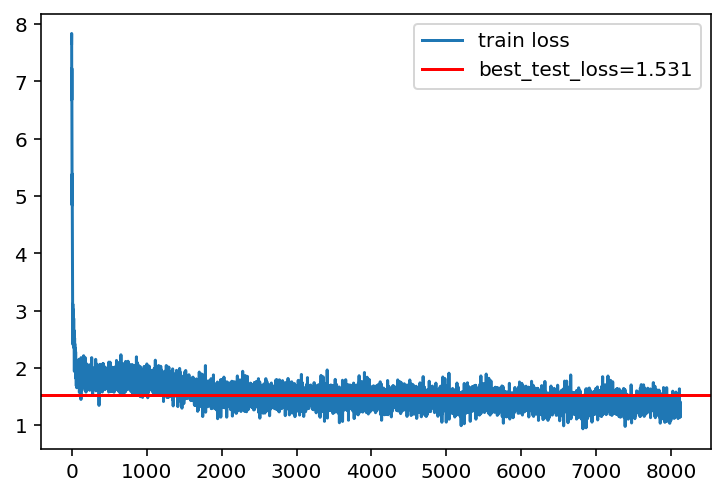

In [53]:
save_loss_map(mv_net,'train')

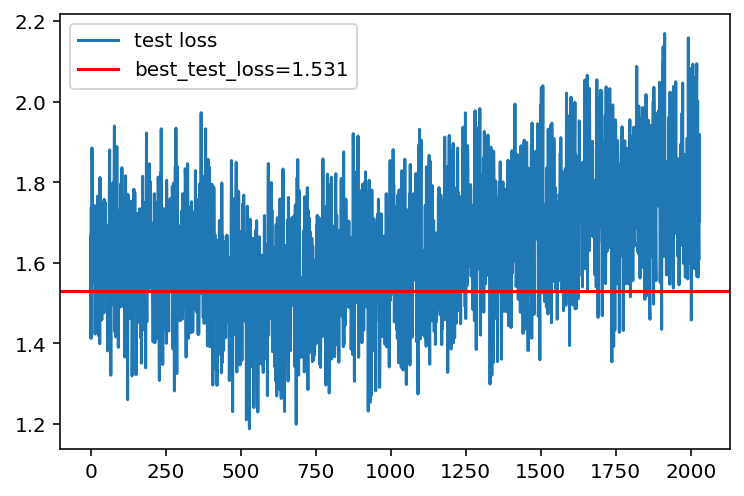

In [54]:
save_loss_map(mv_net,'test')

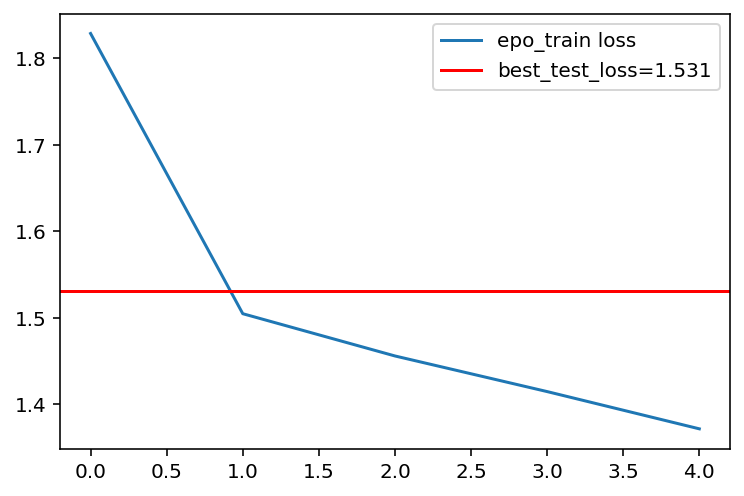

In [55]:
save_loss_map(mv_net,'epo_train')

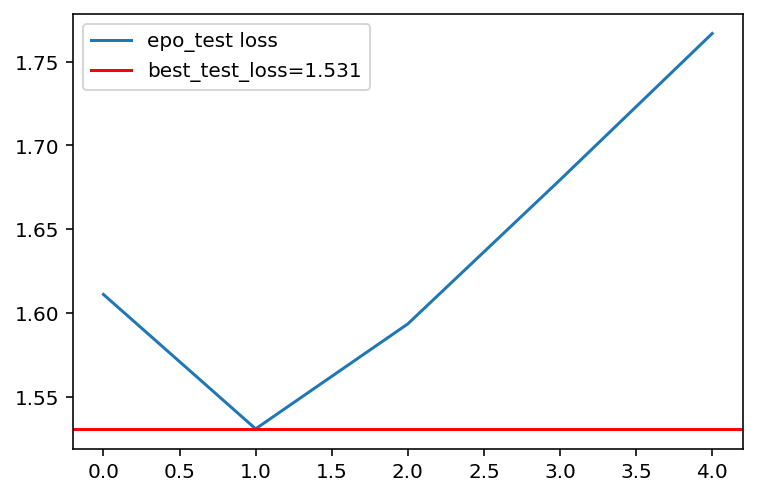

In [56]:
save_loss_map(mv_net,'epo_test')

In [57]:
def create_stocks_matrics(mv_net,stocks,VERSION):
    stock_layer_model = keras.models.Model(inputs=[mv_net.model.input[3], mv_net.model.input[4], mv_net.model.input[5], mv_net.model.input[6], mv_net.model.input[7]], 
                                 outputs=mv_net.model.get_layer("stock_combine_layer_flat").output)
    stock_matrics = []

    for item in stocks.values:
        strategies = np.zeros([1, 40])
        strategies[0] = item.take(4)
        stock_combine_layer_flat_val = stock_layer_model([np.reshape(item.take(0), [1, 1]),
                                                        np.reshape(item.take(1), [1, 1]),
                                                        np.reshape(item.take(2), [1, 1]),
                                                        np.reshape(item.take(3), [1, 1]),
                                                        strategies])  
        stock_matrics.append(stock_combine_layer_flat_val)
    stock_matrics = (np.array(stock_matrics).reshape(-1, 400))
    np.save('./saves/'+str(VERSION)+'/feature_matrix/stock_matrics.npy', stock_matrics)
    return stock_matrics

stock_matrics=create_stocks_matrics(mv_net,stocks,VERSION)

In [58]:
def create_users_matrics(mv_net,users,VERSION):
    user_layer_model = keras.models.Model(inputs=[mv_net.model.input[0], mv_net.model.input[1], mv_net.model.input[2]], 
                                    outputs=mv_net.model.get_layer("user_combine_layer_flat").output)
    users_matrics = []

    for item in users.values:

        user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                        np.reshape(item.take(1), [1, 1]), 
                                                        np.reshape(item.take(2), [1, 1])])
        users_matrics.append(user_combine_layer_flat_val)

    users_matrics = (np.array(users_matrics).reshape(-1, 400))
    np.save('./saves/'+str(VERSION)+'/feature_matrix/users_matrics.npy', users_matrics)
    return users_matrics

users_matrics=create_users_matrics(mv_net,users,VERSION)

In [59]:
def create_inference_matrics(mv_net,users_matrics,stock_matrics,VERSION):
    inference_layer_model = keras.models.Model(inputs=mv_net.model.get_layer("inference_layer").input, 
                                    outputs=mv_net.model.get_layer("inference").output)
    inference_matrics = []
    for u_item in users_matrics:
        temp=[]
        for s_item in stock_matrics:
            inference_layer_val = inference_layer_model([np.reshape(u_item, [1, 400]),
                                                         np.reshape(s_item, [1, 400])])
            temp.append(inference_layer_val)
        inference_matrics.append(temp)
    inference_matrics = (np.array(inference_matrics).reshape(-1, len(stock_matrics)))
    np.save('./saves/'+str(VERSION)+'/feature_matrix/inference_matrics.npy', inference_matrics)
    return inference_matrics

# inference_matrics=create_inference_matrics(mv_net,users_matrics,stock_matrics,VERSION)

### 推薦同類型股票

In [60]:
def load_from_npy(filename):
    return np.load(filename)

# stock_matrics = load_from_npy('./saves/'+str(VERSION)+'/feature_matrix/stock_matrics.npy')
# users_matrics = load_from_npy('./saves/'+str(VERSION)+'/feature_matrix/users_matrics.npy')

In [61]:
def dict_values2key(Dict,value):
    return str(list(Dict.keys())[list(Dict.values()).index(value)])

In [62]:
def recommend_same_type_stock(predict_stock_list,top_k,stockID_map,mkID_map,stock_matrics,stocksid2idx,stocks,sID_filter = lambda x:True):
    results=[]
    for stockID in predict_stock_list:
        stockID_le=stockID_map[stockID]
        mkID = dict_values2key(mkID_map,int(stocks[stocks['stockID_le']==stockID_le]['mkID_le'].values))
        sim = cosine_similarity((stock_matrics[stocksid2idx[stockID_le]]).reshape([1, 400]),stock_matrics)
        sim = np.squeeze(sim)
        sim[stocksid2idx[stockID_le]] = -1
        temp=[]
        for idx in np.argsort(-sim):
            if len(temp) == top_k or sim[idx] < 0.5:
                break
            re_stockID = dict_values2key(stockID_map,stocks.at[idx,'stockID_le'])
            if (not sID_filter(re_stockID)):
                continue
            else:
                re_mkID = dict_values2key(mkID_map,stocks.at[idx,'mkID_le'])
                temp.append([re_mkID,re_stockID,sim[idx]])
        results.append([mkID,stockID,temp])
    return results

In [63]:
def generate_result_df(top_k,stockID_map,mkID_map,stock_matrics,stocksid2idx,stocks,sID_filter,VERSION):
    stock_list=list(filter(lambda x : sID_filter(x),stockID_map.keys()))
    results=recommend_same_type_stock(stock_list,top_k,stockID_map,mkID_map,stock_matrics,stocksid2idx,stocks,sID_filter)
    temp=[]
    for i in results:
        for j in i[2]:
            temp.append([i[0],i[1],VERSION,VERSION,j[0],j[1],j[2]])
                
    result_df_col=['MarketNo','StockID','SourceID','SourceName','RelatedMarketNo','RelatedStockID','RelatedStockProbability']
    result_df=pd.DataFrame(temp,columns=result_df_col)

    result_df.to_csv("./saves/"+VERSION+"/result.csv", index=False)

In [64]:
generate_result_df(20,stockID_map,mkID_map,stock_matrics,stocksid2idx,stocks,sID_filter,VERSION)

In [65]:
def show_from_result_csv(VERSION,stock_list=-1):
    result_type={'MarketNo': 'str', 'StockID': 'str', 'RelatedMarketNo': 'str', 'RelatedStockID': 'str'}
    result_df=pd.read_csv('./saves/'+str(VERSION)+'/result.csv', header=0, dtype=result_type)
    if stock_list == -1:
        stock_list = result_df['StockID'].unique()
    for sID in stock_list:
        first=True
        for index, row in result_df[result_df['StockID']==sID].iterrows():
            if first:
                t_ID=row['MarketNo']+'-'+row['StockID']
                print("選擇的股票為"+t_ID)
            r_ID=row['RelatedMarketNo']+'-'+row['RelatedStockID']
            print("以下是给您的推薦：")
            print('\t'+r_ID+'有{:.3%}'.format(row['RelatedStockProbability']))

In [66]:
stock_list=['2330','2885','2884','2303','2412']
show_from_result_csv(VERSION,stock_list)

選擇的股票為1-2330
以下是给您的推薦：
	1-3042有99.025%
選擇的股票為1-2330
以下是给您的推薦：
	1-2303有98.950%
選擇的股票為1-2330
以下是给您的推薦：
	1-2881有98.837%
選擇的股票為1-2330
以下是给您的推薦：
	1-1476有98.834%
選擇的股票為1-2330
以下是给您的推薦：
	1-1102有98.797%
選擇的股票為1-2330
以下是给您的推薦：
	1-2883有98.657%
選擇的股票為1-2330
以下是给您的推薦：
	1-2352有98.655%
選擇的股票為1-2330
以下是给您的推薦：
	1-2385有98.620%
選擇的股票為1-2330
以下是给您的推薦：
	1-2382有98.598%
選擇的股票為1-2330
以下是给您的推薦：
	1-1101有98.595%
選擇的股票為1-2330
以下是给您的推薦：
	1-2455有98.590%
選擇的股票為1-2330
以下是给您的推薦：
	1-4938有98.586%
選擇的股票為1-2330
以下是给您的推薦：
	1-6176有98.577%
選擇的股票為1-2330
以下是给您的推薦：
	1-2395有98.559%
選擇的股票為1-2330
以下是给您的推薦：
	1-2801有98.547%
選擇的股票為1-2330
以下是给您的推薦：
	1-2891有98.547%
選擇的股票為1-2330
以下是给您的推薦：
	1-2345有98.519%
選擇的股票為1-2330
以下是给您的推薦：
	1-2324有98.506%
選擇的股票為1-2330
以下是给您的推薦：
	1-2454有98.499%
選擇的股票為1-2330
以下是给您的推薦：
	1-2618有98.497%
選擇的股票為1-2885
以下是给您的推薦：
	1-2887有99.677%
選擇的股票為1-2885
以下是给您的推薦：
	1-1101有99.492%
選擇的股票為1-2885
以下是给您的推薦：
	1-5880有99.391%
選擇的股票為1-2885
以下是给您的推薦：
	1-2890有99.357%
選擇的股票為1-2885
以下是给您的推薦：
	1-2882有99.340%
選擇的股票為1-2885
以下是给您的推薦：
	1

In [67]:
stock_list=['2330','2885','2884','2303','2412']
results=recommend_same_type_stock(stock_list,20,stockID_map,mkID_map,stock_matrics,stocksid2idx,stocks,sID_filter)
for i in results:
    print("您選擇的股票為：",i[0],i[1])
    print("以下是给您的推薦：")
    for j in i[2]:
        print(j)

您選擇的股票為： 1 2330
以下是给您的推薦：
['1', '3042', 0.99025315]
['1', '2303', 0.98949677]
['1', '2881', 0.98837036]
['1', '1476', 0.98833734]
['1', '1102', 0.9879738]
['1', '2883', 0.9865746]
['1', '2352', 0.98655164]
['1', '2385', 0.9861977]
['1', '2382', 0.98598367]
['1', '1101', 0.98594815]
['1', '2455', 0.9859021]
['1', '4938', 0.9858633]
['1', '6176', 0.9857695]
['1', '2395', 0.98558986]
['1', '2801', 0.9854708]
['1', '2891', 0.9854702]
['1', '2345', 0.98518914]
['1', '2324', 0.98506254]
['1', '2454', 0.98499346]
['1', '2618', 0.98497176]
您選擇的股票為： 1 2885
以下是给您的推薦：
['1', '2887', 0.9967693]
['1', '1101', 0.994922]
['1', '5880', 0.99391174]
['1', '2890', 0.99356985]
['1', '2882', 0.99340445]
['1', '2881', 0.9933432]
['1', '8046', 0.9931517]
['1', '6239', 0.9930291]
['1', '9910', 0.99285877]
['1', '2412', 0.99280274]
['1', '2880', 0.9927117]
['1', '2002', 0.99264693]
['1', '2618', 0.99262893]
['1', '2884', 0.99226874]
['1', '1301', 0.9922263]
['1', '2207', 0.9919991]
['1', '1605', 0.99190253]
['1

In [68]:
def recommend_personal_stock(mv_net,predict_user_list, top_k ,usersid2idx,userID_map,stocksid2idx,stockID_map,stocks,mkID_map,stock_matrics,users_matrics,sID_filter = lambda x:True):
    inference_layer_model = keras.models.Model(inputs=mv_net.model.get_layer("inference_layer").input, 
                                    outputs=mv_net.model.get_layer("inference").output)
    results=[]
    for userID in predict_user_list:
        userID_le=userID_map[userID]
        u_item=users_matrics[usersid2idx[userID_le]]   
        inference=[]
        for s_item in stock_matrics:
            inference_layer_val = inference_layer_model([np.reshape(u_item, [1, 400]),
                                                         np.reshape(s_item, [1, 400])])
            inference.append(inference_layer_val)
        temp=[]
        for idx in np.argsort(-np.squeeze(inference)):
            if len(temp) == top_k or (not inference[idx] > 0.25):
                break
            re_stockID = dict_values2key(stockID_map,stocks.at[idx,'stockID_le'])
            if (not sID_filter(re_stockID)):
                continue
            else:
                re_mkID = dict_values2key(mkID_map,stocks.at[idx,'mkID_le'])
                temp.append([re_mkID,re_stockID,float(inference[idx])])
        results.append([userID,temp])
    return results

In [69]:
user_list=['637431C61ACE58241Y','637507D3AD2DA0130Y','636739AED4A3F5612Y','6370629CD4ADD6500Y']
results=recommend_personal_stock(mv_net,user_list, 10 ,usersid2idx,userID_map,stocksid2idx,stockID_map,stocks,mkID_map,stock_matrics,users_matrics,sID_filter)
for i in results:
    print("用戶：",i[0])
    print("以下是给您的推薦：")
    for j in i[1]:
        print(j)

用戶： 637431C61ACE58241Y
以下是给您的推薦：
['2', '3484', 3.4623374938964844]
['2', '6241', 3.4233670234680176]
['1', '2609', 3.4210000038146973]
['1', '2603', 3.4103691577911377]
['1', '1558', 3.4059958457946777]
['1', '9934', 3.387333393096924]
['2', '4735', 3.3804140090942383]
['1', '9938', 3.3798635005950928]
['1', '2104', 3.3435773849487305]
['2', '5321', 3.3347105979919434]
用戶： 637507D3AD2DA0130Y
以下是给您的推薦：
['2', '3484', 2.7254762649536133]
['2', '6241', 2.6903586387634277]
['1', '2609', 2.6827378273010254]
['1', '2603', 2.672106981277466]
['1', '1558', 2.6711084842681885]
['1', '9934', 2.6583266258239746]
['1', '9938', 2.6471633911132812]
['2', '4735', 2.645531177520752]
['1', '2104', 2.6137120723724365]
['1', '4440', 2.610036611557007]
用戶： 636739AED4A3F5612Y
以下是给您的推薦：
['2', '3484', 2.790900230407715]
['2', '6241', 2.753709554672241]
['1', '2609', 2.748161554336548]
['1', '1558', 2.7337565422058105]
['1', '2603', 2.7251815795898438]
['1', '9934', 2.723630666732788]
['1', '9938', 2.712587356

In [70]:
def same_strategy(sID1,sID2,stock_data,strategy_data):
    set_x=set(*stock_data[stock_data['stockID_or']==sID1]['strategyList_or'])
    set_y=set(*stock_data[stock_data['stockID_or']==sID2]['strategyList_or'])
    result_df = pd.DataFrame((set_x & set_y),columns=['strategyID_or'])
    result_df=result_df.merge(strategy_data[['strategyID_or','strategyCN']], how='inner', on='strategyID_or')
    return result_df

In [71]:
def clk2clk_rate(sID1,sID2,click_gp):
    set_x=set(click_gp.get_group(sID1)['userID_or'])
    set_y=set(click_gp.get_group(sID2)['userID_or'])
    a2b=len(set_x & set_y)/len(set_x)
    b2a=len(set_x & set_y)/len(set_y)
    return a2b,b2a

In [72]:
def evaluate_all(VERSION,click_data,stock_data,strategy_data):
    result_type={'MarketNo': 'str', 'StockID': 'str', 'RelatedMarketNo': 'str', 'RelatedStockID': 'str'}
    result_df=pd.read_csv('./saves/'+str(VERSION)+'/result.csv', header=0, dtype=result_type)
    evaluate_df_col=['t_mID','t_sID','r_mID','r_sID','same_strategy','t2r','r2t']
    click_gp = click_data.groupby("stockID_or")
    data=[]
    for index, row in result_df.iterrows():
        temp=[]    
        #target_id
        temp.extend([row["MarketNo"],row["StockID"]])
        #recommend_id
        temp.extend([row["RelatedMarketNo"],row["RelatedStockID"]])
        #same_strategy
        ss_df=same_strategy(row["StockID"],row["RelatedStockID"],stock_data,strategy_data)
        temp.append([[i,j] for i,j in zip(ss_df['strategyID_or'],ss_df['strategyCN'])])
        #t2r    
        temp.extend(clk2clk_rate(row["StockID"],row["RelatedStockID"],click_gp))

        data.append(temp)
    evaluate_df=pd.DataFrame(data,columns=evaluate_df_col)
    evaluate_df.to_csv("./saves/"+VERSION+"/evaluate.csv", index=False)

In [73]:
evaluate_all(VERSION,click_data,stock_data,strategy_data)

In [74]:
def show_from_evaluate_csv(VERSION,stock_list=-1):
    evaluate_type={'t_mID': 'str', 't_sID': 'str','r_mID': 'str', 'r_sID': 'str'}
    evaluate_df=pd.read_csv('./saves/'+str(VERSION)+'/evaluate.csv', header=0, dtype=evaluate_type)
    if stock_list == -1:
        stock_list = evaluate_df['t_sID'].unique()
    for sID in stock_list:
        for index, row in evaluate_df[evaluate_df['t_sID']==sID].iterrows():
            t_ID=row['t_mID']+'-'+row['t_sID']
            r_ID=row['r_mID']+'-'+row['r_sID']
            print("對"+t_ID+'推薦'+r_ID)
            print("可能原因:\n\t相同策略:")
            for ss in eval(row['same_strategy']):
                print("\t\t"+str(ss[0])+":"+ss[1])
            print("\n\t點擊"+t_ID+"的使用者有"+'{:.3%}'.format(row['t2r'])+"點擊了"+r_ID)
            print("\t點擊"+r_ID+"的使用者有"+'{:.3%}'.format(row['r2t'])+"點擊了"+t_ID+"\n")

In [75]:
show_from_evaluate_csv(VERSION,["2330"])

對1-2330推薦1-3042
可能原因:
	相同策略:
		510016003:近一季營收創新高
		510016005:近四季有三季EPS年增>10%
		510016009:近四季有三季營益率>10%
		510016010:近四季有三季毛利率>30%
		510016014:現金股利>3元
		510016027:季上市櫃市值前300大
		510016029:上市公司治理評鑑前20%
		510013001:Apple
		560001000:隔日沖-1號
		510033001:上市全部
		510033003:權證發行標的
		510033004:平均月交易量大於1500
		510033005:季上市櫃市值前300大
		510033006:季上市櫃市值前500大
		510033010:股票期貨成分股
		510033014:日上市櫃市值前300大
		510033015:當日切換-季上市櫃市值前300大
		510033016:日上市櫃市值前500大
		510033017:當日切換-季上市櫃市值前500大
		510022010:短線空單標的股

	點擊1-2330的使用者有1.412%點擊了1-3042
	點擊1-3042的使用者有31.393%點擊了1-2330

對1-2330推薦1-2303
可能原因:
	相同策略:
		510016003:近一季營收創新高
		510016005:近四季有三季EPS年增>10%
		510016009:近四季有三季營益率>10%
		510016015:MSCI成分股
		510016024:台灣50成分股
		510016027:季上市櫃市值前300大
		510016029:上市公司治理評鑑前20%
		510016031:台灣ESG成分股
		510025014:瞬間巨量大於300張
		510014016:IC-代工
		560001000:隔日沖-1號
		510033001:上市全部
		510033003:權證發行標的
		510033004:平均月交易量大於1500
		510033005:季上市櫃市值前300大
		510033006:季上市櫃市值前500大
		510033007:MSCI成分股
		510033008:台灣50成分股
		510033010:股票期貨成分股
		5

In [76]:
def evaluate_stock(VERSION,stock_list,click_data,stock_data,strategy_data):
    result_type={'MarketNo': 'str', 'StockID': 'str', 'RelatedMarketNo': 'str', 'RelatedStockID': 'str'}
    result_df=pd.read_csv('./saves/'+str(VERSION)+'/result.csv', header=0, dtype=result_type)
    click_gp = click_data.groupby("stockID_or")
    for sID in stock_list:
        for index, row in result_df[result_df['StockID']==sID].iterrows():
            t_ID=row["MarketNo"]+'-'+row["StockID"]
            r_ID=row['RelatedMarketNo']+'-'+row['RelatedStockID']
            print("對"+t_ID+'推薦'+r_ID)
            print("可能原因:\n\t相同策略:")
            ss_df=same_strategy(row["StockID"],row["RelatedStockID"],stock_data,strategy_data)
            for i,j in zip(ss_df['strategyID_or'],ss_df['strategyCN']):
                print("\t\t"+str(i)+":"+j)
            t2r,r2t=clk2clk_rate(row["StockID"],row["RelatedStockID"],click_gp)
            print("\n\t點擊"+t_ID+"的使用者有"+'{:.3%}'.format(t2r)+"點擊了"+r_ID)
            print("\t點擊"+r_ID+"的使用者有"+'{:.3%}'.format(r2t)+"點擊了"+t_ID+"\n")

In [77]:
evaluate_stock(VERSION,["0050","2330"],click_data,stock_data,strategy_data)

對1-0050推薦1-2406
可能原因:
	相同策略:
		510017001:外資連3買
		510033004:平均月交易量大於1500
		510018006:股價在月線上&月線上揚
		510018009:月均線回升
		510017022:近一日籌碼大買

	點擊1-0050的使用者有1.022%點擊了1-2406
	點擊1-2406的使用者有3.641%點擊了1-0050

對1-0050推薦1-6672
可能原因:
	相同策略:
		510033004:平均月交易量大於1500
		510018006:股價在月線上&月線上揚
		510016014:現金股利>3元

	點擊1-0050的使用者有0.079%點擊了1-6672
	點擊1-6672的使用者有1.639%點擊了1-0050

對1-0050推薦1-2069
可能原因:
	相同策略:
		510018009:月均線回升
		510017022:近一日籌碼大買
		510033004:平均月交易量大於1500
		510018006:股價在月線上&月線上揚

	點擊1-0050的使用者有0.590%點擊了1-2069
	點擊1-2069的使用者有3.571%點擊了1-0050

對1-0050推薦1-0056
可能原因:
	相同策略:
		510028001:全部
		510028002:臺灣
		510029001:全部
		510017001:外資連3買
		510033003:權證發行標的
		510033004:平均月交易量大於1500
		510038001:國內外成分證券ETF
		510033010:股票期貨成分股
		510038004:其他ETF
		510033015:當日切換-季上市櫃市值前300大
		510033017:當日切換-季上市櫃市值前500大

	點擊1-0050的使用者有28.105%點擊了1-0056
	點擊1-0056的使用者有28.028%點擊了1-0050

對1-0050推薦1-3092
可能原因:
	相同策略:
		510017001:外資連3買
		510033003:權證發行標的
		510033004:平均月交易量大於1500
		510018006:股價在月線上&月線上揚
		510018009:月均線回升

	點擊1-0050的使用者

		510016009:近四季有三季營益率>10%
		510016010:近四季有三季毛利率>30%
		510016014:現金股利>3元
		510016015:MSCI成分股
		510016024:台灣50成分股
		510016027:季上市櫃市值前300大
		510016031:台灣ESG成分股
		510018006:股價在月線上&月線上揚
		560001000:隔日沖-1號
		510017001:外資連3買
		510033001:上市全部
		510033003:權證發行標的
		510033004:平均月交易量大於1500
		510033005:季上市櫃市值前300大
		510033006:季上市櫃市值前500大
		510033007:MSCI成分股
		510033008:台灣50成分股
		510033010:股票期貨成分股
		510033014:日上市櫃市值前300大
		510033015:當日切換-季上市櫃市值前300大
		510033016:日上市櫃市值前500大
		510033017:當日切換-季上市櫃市值前500大
		510022010:短線空單標的股

	點擊1-2330的使用者有5.943%點擊了1-1101
	點擊1-1101的使用者有40.465%點擊了1-2330

對1-2330推薦1-2455
可能原因:
	相同策略:
		510016003:近一季營收創新高
		510016009:近四季有三季營益率>10%
		510016010:近四季有三季毛利率>30%
		510016027:季上市櫃市值前300大
		510013001:Apple
		510013003:物聯網
		510018006:股價在月線上&月線上揚
		510013024:	華為手機
		560001000:隔日沖-1號
		510033001:上市全部
		510033003:權證發行標的
		510033004:平均月交易量大於1500
		510033005:季上市櫃市值前300大
		510033006:季上市櫃市值前500大
		510033010:股票期貨成分股
		510033014:日上市櫃市值前300大
		510033016:日上市櫃市值前500大
		510033017:當日切換-季上市櫃市值前50